# Análisis a 0º

Primero se importan los paquetes necesarios:

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Messinger
from Messinger import fem_velocidades  
import Messinger.Procesado_aerodinamico
from Messinger.Procesado_aerodinamico import Procesado_aerodinamico
from Messinger.Procesado_termico import procesado_termico,calcular_fraccion_congelacion
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pywt
import tkinter as tk
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
import scipy
from tkinter import filedialog
from tkinter import *
from sklearn.metrics import r2_score
os.chdir('Messinger')

Se define un data frame con las posiciones de los sensores en s(mm)

In [2]:

df = pd.DataFrame(data =[[0,4,9,18,28,38,48,58],['A8','A7','A6','A5','A4','A3','A2','A1']])
df=df.T
df.columns = ['s(mm)','sensor']
print(df)

  s(mm) sensor
0     0     A8
1     4     A7
2     9     A6
3    18     A5
4    28     A4
5    38     A3
6    48     A2
7    58     A1


Se pasa ese arco al eje x

In [3]:
MVD=40
T_remanso=-5
LWC=0.9
V=int(70)
x_experimental=[0,0.01,0.02]
T_experimental=[0,0.0,0.0]
angulo_ataque =5
zona='intrados'
(Elementos,Velocidades,Superficie,Puntos)=Procesado_aerodinamico(70,angulo_ataque)
Superficie = Superficie[Superficie['y']>=0]
Modelo = fem_velocidades.modelo_fem(Elementos,Velocidades,Superficie,Puntos)

x_superficie=np.array(Superficie['x'])
y_superficie = np.array(Superficie['y'])
s_perfil = [0]
for i in range(1,len(Modelo.x_superficie)):
    
    delta_S= (Modelo.x_superficie[i]-Modelo.x_superficie[i-1])**2+(Modelo.y_superficie[i]-Modelo.y_superficie[i-1])**2
    s_perfil.append(np.sqrt(delta_S)+s_perfil[-1])
X=[] 
df['s(m)'] =df['s(mm)']*10**-3  
for s in df['s(m)']:    
    for i in range(1,len(s_perfil)):     
            if s>=s_perfil[i-1] and s<=s_perfil[i]:
                X.append(Modelo.x_superficie[i-1]+(Modelo.x_superficie[i]-Modelo.x_superficie[i-1])/(s_perfil[i]-s_perfil[i-1])*(s-s_perfil[i-1]))
                break
# In[17]:
df['x(m)']=X
print(df)


# In[28]:


X={}
for i in range(len(df['x(m)'])-1):
    n_sensor=int(df['sensor'].loc[i][-1])
    X.update({'FBG'+str(n_sensor):df['x(m)'].loc[i]})
    

print(X)

  s(mm) sensor   s(m)      x(m)
0     0     A8      0  0.000000
1     4     A7  0.004  0.001671
2     9     A6  0.009  0.005760
3    18     A5  0.018  0.014189
4    28     A4  0.028  0.023944
5    38     A3  0.038  0.033834
6    48     A2  0.048  0.043784
7    58     A1  0.058  0.053762
{'FBG8': 0.0, 'FBG7': 0.0016705991013616515, 'FBG6': 0.005760419605643688, 'FBG5': 0.014189248476926417, 'FBG4': 0.023944133029938086, 'FBG3': 0.033833857473507284, 'FBG2': 0.04378366706833141}


Perfil de temperaturas en el perfil

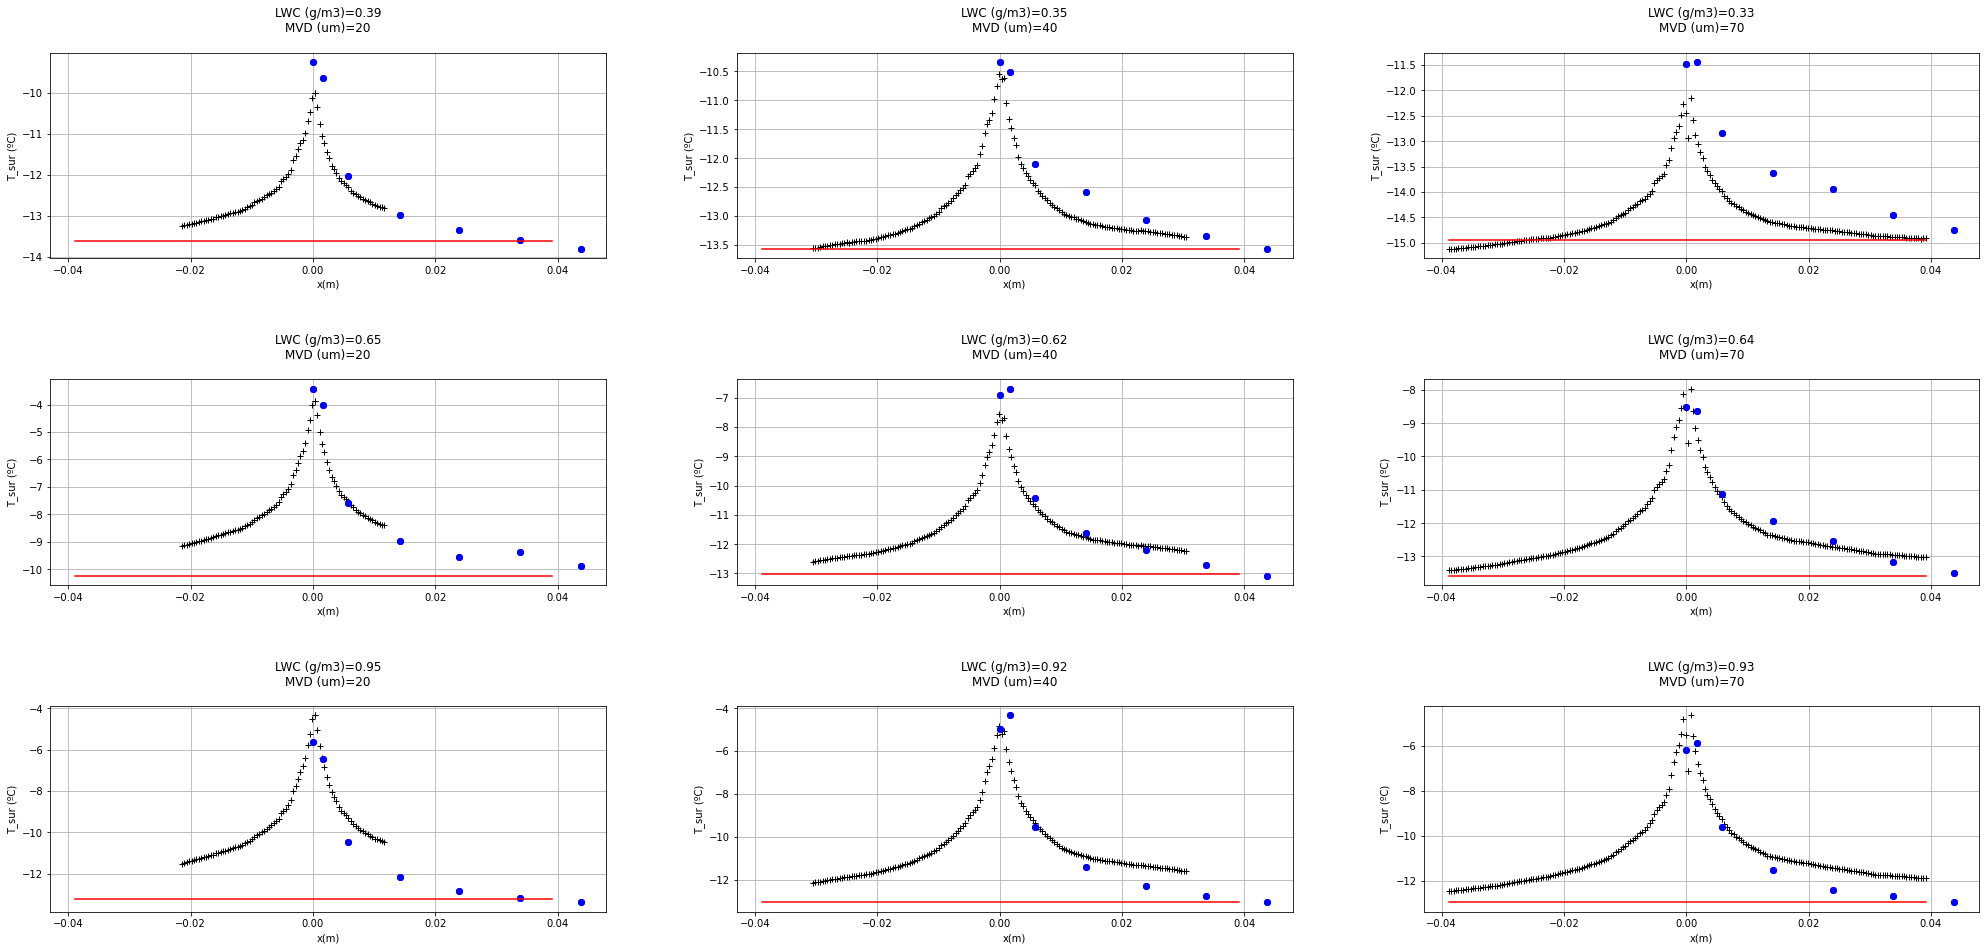

In [4]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize =(30,15))

fig.tight_layout(pad=10.0)
columna = 0
fila = 0
Datos_rime=[]
for mvD in ['4','5','6']:
    fila = 0
    for lwC in ['A','B','C']:
        nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+mvD+lwC+'.txt'
        file = open(nombre_archivo,'r')
        lineas = file.readlines()
        file.close()
        LWC = lineas[1]
        for caracter in range(len(LWC)):
            if LWC[caracter]=='=':
                lwc = float(LWC[caracter+1:-1])
        MVD = lineas[2]
        for caracter in range(len(MVD)):
            if MVD[caracter]=='=':
                mvd = int(MVD[caracter+1:-1])
        df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
        if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
        df = df[df['Tiempo (s)']<140]
        df.index =df['Tiempo (s)']
        x_experimental = [0,0.01,0.02,0.039]
        T_experimental = [-2.5, -3,-5.5,-5.5]
        LWC=lwc
        V=70
        ax[fila,columna].set_title(str(lineas[1])+ str(MVD))
        T_remanso=np.mean(df['FBG1'].loc[70:80])
        MVD = mvd
        alpha=0
        zona_estudio = 'extrados'
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        for i in X:
            x = X[i]
            for j in range(len(x_ext)-1):
                if x>= x_ext[j] and x<= x_ext[j+1] and x>=0 and T_sur_ext[j]>=-200:
                    # ax[fila,columna].plot(x_ext[j],T_sur_ext[j],'ob')
                    # ax[fila,columna].text(x_ext[j],T_sur_ext[j],i)
                    Datos_rime.append([x_ext[j],T_sur_ext[j],i,mvd,lwc])
                    break
        zona_estudio = 'intrados'
        (x_int,T_sur_int)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        for iteracion,T in enumerate(T_sur_int):
            
            if T <-200:T_sur_int[iteracion]=np.nan
        for i in X:
            x = X[i]
            for j in range(len(x_int)-1):
                if x<= x_int[j] and x>= x_int[j+1] and x<=0 and T_sur_int[j]>=-200:
                    # ax[fila,columna].plot(x_int[j],T_sur_int[j],'ob')
                    # ax[fila,columna].text(x_int[j],T_sur_int[j],i)
                    Datos_rime.append([x_int[j],T_sur_int[j],i,mvd,lwc])
                    break
        ax[fila,columna].plot(x_ext,T_sur_ext,'+k',label='analitic')
        ax[fila,columna].plot(x_int,T_sur_int,'+k')
        ax[fila,columna].set_xlabel('x(m)')
        ax[fila,columna].set_ylabel('T_sur (ºC)')
        ax[fila,columna].grid()
        Posiciones = []
        temperaturas =[]
        for sensor in X:
            try:
                temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
            except:
                temperaturas.append(np.nan)
            Posiciones.append(X[sensor])
            ax[fila,columna].plot([Posiciones[-1],Posiciones[-1]],[temperaturas[-1],temperaturas[-1]],'ob',label='experimental')
        ax[fila,columna].plot([min(x_int),max(x_ext)],[T_remanso,T_remanso],'r',label='experimental')
        fila = fila + 1
    ax[fila-1,columna].set_xlabel('x(m)')
    columna = columna + 1

## Ensayo 6C


        

Se extraen los perfiles de temperaturas en el perfil

In [5]:
def procesado_termico(angulo_ataque,LWC,T_remanso,MVD,zona,V):
   global pto_remanso 
   import __main__

   x_experimental=__main__.x_experimental
   
   betha=pickle.load(open('Eficiencias_coleccion//betha'+str(V)+'_'+str(angulo_ataque)+'_'+str(MVD)+'.p', "rb"))
   Modelo_termico = fem_velocidades.analisis_termico()
   Modelo_termico.calculo_S(Modelo)
   Modelo_termico.set_zona_perfil(zona)
   Modelo_termico.set_T_remanso(T_remanso+273.15)
   Modelo_termico.x_experimental = __main__.x_experimental
   Modelo_termico.T_experimental = __main__.T_experimental
   Modelo_termico.set_recovery_factor(1)
   Modelo_termico.set_presion_remanso(101325)
   Modelo_termico.set_LWC(LWC)

   Modelo_termico.set_diametro_caracteristico(0.02)
   Modelo_termico.set_velocidad_flujo(V)
   Modelo_termico.set_freezing_fraction(0.8)
   Modelo_termico.set_flujo_masico_entrada(0)
   Modelo_termico.set_T_superficie_anterior(273.15)
   Modelo_termico.set_cp_ws_anterior(1.004)
   Modelo_termico.set_T_superficie(273.15)
   Modelo_termico.set_local_collection_efficiency(0.5)
   Modelo_termico.set_freezing_fraction(1)
   Modelo_termico.set_tamano_gota(20e-6)
   Modelo_termico.V_e = Modelo_termico.V
   Modelo_termico.T_estatica = Modelo_termico.T_remanso -Modelo_termico.V**2/2/1004.5
   Modelo_termico.set_coeficiente_convectivo(400)
   Modelo_termico.calculo_todos_calores()
   Modelo_termico.Modelo_CFD = Modelo
   pto_remanso=Modelo_termico.x_remanso
   Modelo_termico.betha_nodos = betha
   h_l=[Modelo_termico.coeficiente_convectivo_laminar(Modelo_termico.longitud_equivalente(i)) for i in x_experimental]
   h_l[0]=h_l[1]
   
   Modelo_termico.coeficiente_convectivo_valores = h_l
   (x,T_sur)=Modelo_termico.calculate_T_sur()
  
   return (np.array(x)+pto_remanso,T_sur)

In [6]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'6'+'C'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

In [7]:
(Elementos,Velocidades,Superficie,Puntos)=Procesado_aerodinamico(V,angulo_ataque)
Modelo = fem_velocidades.modelo_fem(Elementos,Velocidades,Superficie,Puntos)
Modelo.set_T_remanso(273.15+T_remanso)
Modelo.set_presion_remanso(1e5)
from sklearn.metrics import r2_score

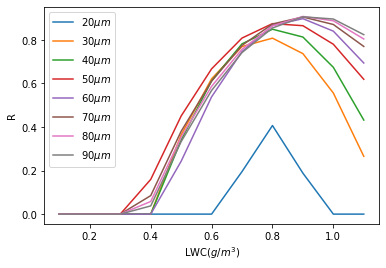

In [8]:

for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('6C.png')

## Ensayo 6B

In [9]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'6'+'B'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

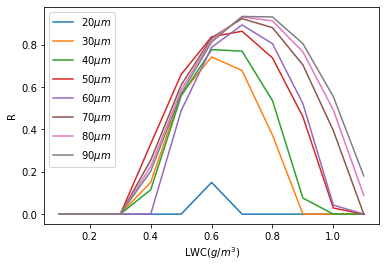

In [10]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('6B.png')

## Ensayo 6A

In [11]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'6'+'A'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

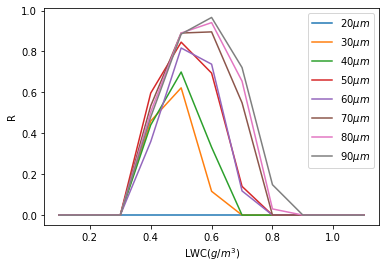

In [12]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('6A.png')

## Ensayo 5C

In [13]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'5'+'C'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

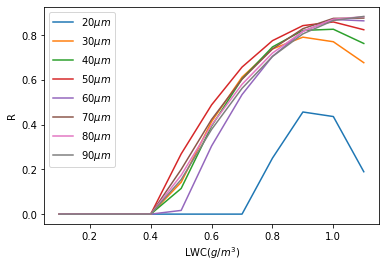

In [14]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('5C.png')

## Ensayo 5B

In [15]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'5'+'B'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

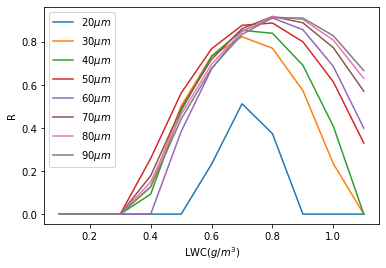

In [16]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('5B.png')

## Ensayo 5A

In [17]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'5'+'A'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

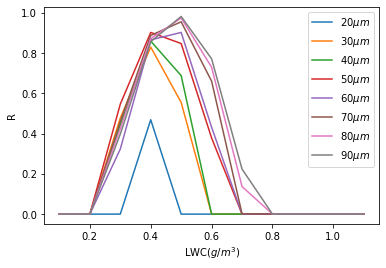

In [18]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('4B.png')

## Ensayo 4C

In [19]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'4'+'C'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

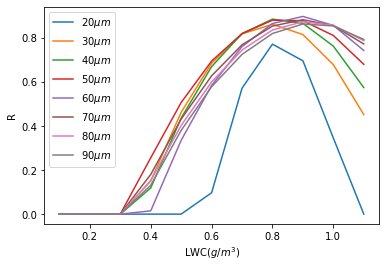

In [20]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('4C.png')

## Ensayos 4B

In [21]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'4'+'B'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

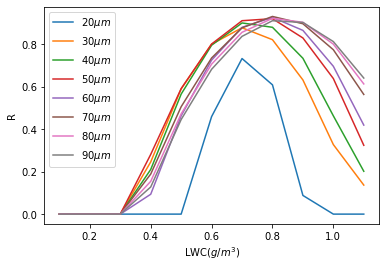

In [22]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('4B.png')

## Ensayos 4A

In [23]:
nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+'4'+'A'+'.txt'
zona_estudio = 'extrados'
Posiciones = []
temperaturas =[]

file = open(nombre_archivo,'r')
lineas = file.readlines()
file.close()
LWC = lineas[1]
for caracter in range(len(LWC)):
    if LWC[caracter]=='=':
        lwc = float(LWC[caracter+1:-1])
MVD = lineas[2]
for caracter in range(len(MVD)):
    if MVD[caracter]=='=':
        mvd = int(MVD[caracter+1:-1])
df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
df = df[df['Tiempo (s)']<140]
df.index =df['Tiempo (s)']
T_remanso=np.mean(df['FBG1'].loc[70:80])
for sensor in X:
    try:
        temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
    except:
        temperaturas.append(np.nan)
    Posiciones.append(X[sensor])

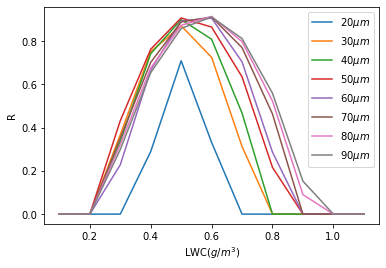

In [24]:
for MVD in [20,30,40,50,60,70,80,90]:
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,MVD,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    plt.plot(np.arange(0.1,1.2,0.1),R,label=f'{MVD}$\mu m$')
plt.xlabel(f'LWC($g/m^{3}$)')
plt.ylabel('R')
plt.legend()
plt.savefig('4A.png')

Se puede ver que en el caso de veinte micras el valor R es muy bajo. Las gráficas son muy interesantes, ya que se ve que a tamaños de gota grandes, las gráficas se parecen bastante (R alta). Eso puede ser porque el modelo no es exacto en gotas grandes. Por ello se comparan los valores al resultado con veinte micras: 

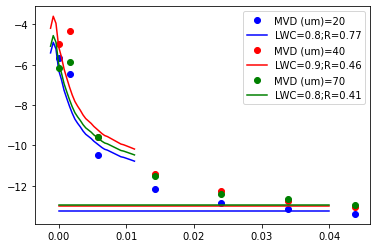

In [47]:
#for contenido_agua_liquido in ['A','B','C']:
contenido_agua_liquido='C'
plt.figure()
colores={'4'+contenido_agua_liquido:'b','5'+contenido_agua_liquido:'r','6'+contenido_agua_liquido:'g'}
for condicion in colores:
    nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+condicion+'.txt'
    zona_estudio = 'extrados'
    Posiciones = []
    temperaturas =[]
    alpha = 0
    file = open(nombre_archivo,'r')
    lineas = file.readlines()
    file.close()
    LWC = lineas[1]
    for caracter in range(len(LWC)):
        if LWC[caracter]=='=':
            lwc = float(LWC[caracter+1:-1])
    MVD = lineas[2]
    for caracter in range(len(MVD)):
        if MVD[caracter]=='=':
            mvd = int(MVD[caracter+1:-1])
    df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
    if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
    df = df[df['Tiempo (s)']<140]
    df.index =df['Tiempo (s)']
    T_remanso=np.mean(df['FBG1'].loc[70:80])
    for sensor in X:
        try:
            temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
        except:
            temperaturas.append(np.nan)
        Posiciones.append(X[sensor])
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,20,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    for i in range(len(R)):
        if R[i]==max(R):
            LWC = np.arange(0.1,1.2,0.1)[i]
    plt.plot(Posiciones,temperaturas,colores[condicion]+'o',label=MVD[:-1])
    (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,20,zona_estudio,V)
    plt.plot(x_ext,T_sur_ext,colores[condicion],label=f'LWC={LWC};R={round(max(R),2)}')
    plt.plot([0,0.04],[T_remanso,T_remanso],colores[condicion])
plt.legend()

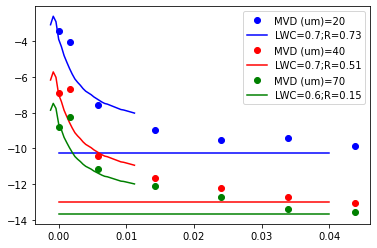

In [49]:
contenido_agua_liquido='B'
plt.figure()
colores={'4'+contenido_agua_liquido:'b','5'+contenido_agua_liquido:'r','6'+contenido_agua_liquido:'g'}
for condicion in colores:
    nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+condicion+'.txt'
    zona_estudio = 'extrados'
    Posiciones = []
    temperaturas =[]
    alpha = 0
    file = open(nombre_archivo,'r')
    lineas = file.readlines()
    file.close()
    LWC = lineas[1]
    for caracter in range(len(LWC)):
        if LWC[caracter]=='=':
            lwc = float(LWC[caracter+1:-1])
    MVD = lineas[2]
    for caracter in range(len(MVD)):
        if MVD[caracter]=='=':
            mvd = int(MVD[caracter+1:-1])
    df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
    if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
    df = df[df['Tiempo (s)']<140]
    df.index =df['Tiempo (s)']
    T_remanso=np.mean(df['FBG1'].loc[70:80])
    for sensor in X:
        try:
            temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
        except:
            temperaturas.append(np.nan)
        Posiciones.append(X[sensor])
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,20,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    for i in range(len(R)):
        if R[i]==max(R):
            LWC = np.arange(0.1,1.2,0.1)[i]
    plt.plot(Posiciones,temperaturas,colores[condicion]+'o',label=MVD[:-1])
    (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,20,zona_estudio,V)
    plt.plot(x_ext,T_sur_ext,colores[condicion],label=f'LWC={round(LWC,2)};R={round(max(R),2)}')
    plt.plot([0,0.04],[T_remanso,T_remanso],colores[condicion])
plt.legend()
            

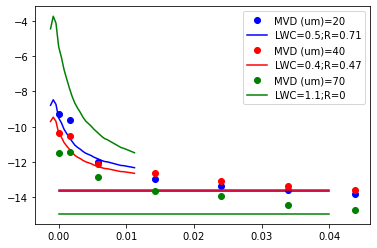

In [50]:
contenido_agua_liquido='A'
plt.figure()
colores={'4'+contenido_agua_liquido:'b','5'+contenido_agua_liquido:'r','6'+contenido_agua_liquido:'g'}
for condicion in colores:
    nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+condicion+'.txt'
    zona_estudio = 'extrados'
    Posiciones = []
    temperaturas =[]
    alpha = 0
    file = open(nombre_archivo,'r')
    lineas = file.readlines()
    file.close()
    LWC = lineas[1]
    for caracter in range(len(LWC)):
        if LWC[caracter]=='=':
            lwc = float(LWC[caracter+1:-1])
    MVD = lineas[2]
    for caracter in range(len(MVD)):
        if MVD[caracter]=='=':
            mvd = int(MVD[caracter+1:-1])
    df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
    if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
    df = df[df['Tiempo (s)']<140]
    df.index =df['Tiempo (s)']
    T_remanso=np.mean(df['FBG1'].loc[70:80])
    for sensor in X:
        try:
            temperaturas.append(float(np.mean(df[sensor].loc[70:80])))
        except:
            temperaturas.append(np.nan)
        Posiciones.append(X[sensor])
    R = []
    for LWC in np.arange(0.1,1.2,0.1):
        (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,20,zona_estudio,V)
        T_predict = []
        T_real=[]
        for i in range(len(Posiciones)):
            for j in range(len(x_ext)-1):
                if Posiciones[i]>=x_ext[j] and  Posiciones[i]<=x_ext[j+1]:
                    if str(T_sur_ext[j])!='nan':
                        T_predict.append(T_sur_ext[j])
                        T_real.append(temperaturas[i])
        try:
            R.append(r2_score(T_real,T_predict))
            if R[-1]<0:R[-1]=0
        except:R.append(np.nan)
    for i in range(len(R)):
        if R[i]==max(R):
            LWC = np.arange(0.1,1.2,0.1)[i]
    plt.plot(Posiciones,temperaturas,colores[condicion]+'o',label=MVD[:-1])
    (x_ext,T_sur_ext)=procesado_termico(alpha,LWC,T_remanso,20,zona_estudio,V)
    plt.plot(x_ext,T_sur_ext,colores[condicion],label=f'LWC={round(LWC,2)};R={round(max(R),2)}')
    plt.plot([0,0.04],[T_remanso,T_remanso],colores[condicion])
plt.legend()

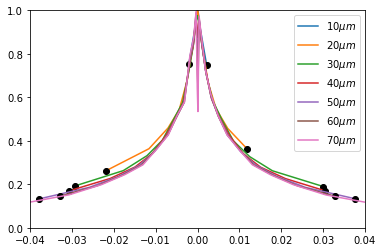

In [70]:
for mvd in np.arange(10,80,10):
    betha=pickle.load(open('Eficiencias_coleccion//betha'+str(V)+'_'+str(0)+'_'+str(mvd)+'.p', "rb"))
    plt.plot(betha[:,0],betha[:,1],label=f'{mvd}$\mu m$')
    plt.plot(betha[-1,0],betha[-1,1],'ok')
    plt.plot(betha[0,0],betha[0,1],'ok')
    plt.axis([-0.04,0.04,0,1])
plt.legend()

## Límites de colección de Hielo

Se van a analizar en que puntos hay límites de colección en el perfil a LWC constante:

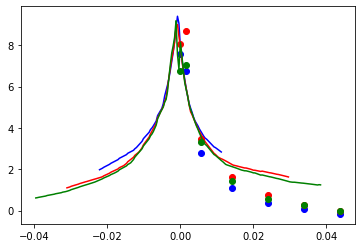

In [73]:
contenido_agua_liquido='C'
plt.figure()
colores={'4'+contenido_agua_liquido:'b','5'+contenido_agua_liquido:'r','6'+contenido_agua_liquido:'g'}
for condicion in colores:
    nombre_archivo ='C://Users//gonzalezvm//programa hielo//P35_0_grados_rime//ensayo_'+condicion+'.txt'
    zona_estudio = 'extrados'
    Posiciones = []
    temperaturas =[]
    alpha = 0
    file = open(nombre_archivo,'r')
    lineas = file.readlines()
    file.close()
    LWC = lineas[1]
    for caracter in range(len(LWC)):
        if LWC[caracter]=='=':
            lwc = float(LWC[caracter+1:-1])
    MVD = lineas[2]
    for caracter in range(len(MVD)):
        if MVD[caracter]=='=':
            mvd = int(MVD[caracter+1:-1])
    df = pd.read_csv(nombre_archivo,header=3,sep='\t',index_col=False)
    if mvD+lwC=='6B':df['Tiempo (s)'] = df['Tiempo (s)']+20
    df = df[df['Tiempo (s)']<140]
    df.index =df['Tiempo (s)']
    T_remanso=np.mean(df['FBG1'].loc[70:80])
    for sensor in X:
        try:
            temperaturas.append(float(np.mean(df[sensor].loc[70:80]))-T_remanso)
        except:
            temperaturas.append(np.nan)
        Posiciones.append(X[sensor])
    plt.plot(Posiciones,temperaturas,colores[condicion]+'o',label=MVD[:-1])
    (x_ext,T_sur_ext)=procesado_termico(alpha,0.9,T_remanso,mvd,zona_estudio,V)
    
    plt.plot(x_ext,T_sur_ext-T_remanso,colores[condicion],label=f'{LWC}R={round(max(R),2)}')
    (x_ext,T_sur_ext)=procesado_termico(alpha,0.9,T_remanso,mvd,'intrados',V)
    plt.plot(x_ext,T_sur_ext-T_remanso,colores[condicion])
    #plt.plot([0,0.06],[T_remanso,T_remanso],colores[condicion])
#plt.legend()
#plt.axis([0,0.05,-13.5,-12])